In [ ]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape,RNN
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [ ]:
import random
import tensorflow as tf
random.seed(12345)
np.random.seed(27)
tf.random.set_seed(145)

(2115, 22, 1000)


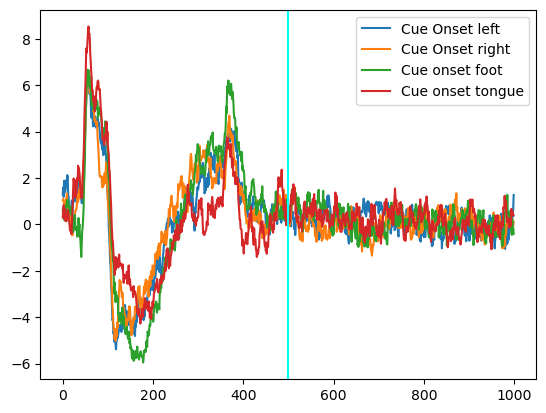

In [ ]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






In [ ]:
def train_data_prep(X,y,sub_sample,average,noise):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)


    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X




In [ ]:
X_train_valid.shape

(2115, 22, 1000)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:

## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting

x_train, x_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.1)

## Preprocessing the dataset

x_train, y_train = train_data_prep(x_train,y_train,2,2,True)
x_valid, y_valid = train_data_prep(x_valid,y_valid,2,2,True)
X_test_prep = test_data_prep(X_test)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of X after trimming: (1903, 22, 800)
Shape of X after maxpooling: (1903, 22, 400)
Shape of X after averaging+noise and concatenating: (3806, 22, 400)
Shape of X after subsampling and concatenating: (7612, 22, 400)
Shape of Y: (7612,)
Shape of X after trimming: (212, 22, 800)
Shape of X after maxpooling: (212, 22, 400)
Shape of X after averaging+noise and concatenating: (424, 22, 400)
Shape of X after subsampling and concatenating: (848, 22, 400)
Shape of Y: (848,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of training set: (7612, 22, 400)
Shape of validation set: (848, 22, 400)
Shape of training labels: (7612,)
Shape of validation labels: (848,)
Shape of training labels after categorical conversion: (7612, 4)
Shape of validation labels after categorical conversion: (848, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7612, 22, 400, 1)
Shape of validation set after addi

In [ ]:
from keras.regularizers import l2

In [ ]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(3,1), padding='same', activation='elu', kernel_regularizer=l2(0.001), input_shape=(400,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='valid')) # Read the keras documentation
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(3,1), padding='same', activation='elu', kernel_regularizer=l2(0.001)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='valid'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(3,1), padding='same', activation='elu', kernel_regularizer=l2(0.001)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='valid'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
# basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu', kernel_regularizer=l2(0.001)))
# basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='valid'))
# basic_cnn_model.add(BatchNormalization())
# basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense((40))) # FC layer with 100 units
basic_cnn_model.add(Dropout(0.5))
basic_cnn_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
basic_cnn_model.add(LSTM(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False))
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_191 (Conv2D)         (None, 400, 1, 25)        1675      
                                                                 
 max_pooling2d_191 (MaxPool  (None, 133, 1, 25)        0         
 ing2D)                                                          
                                                                 
 batch_normalization_191 (B  (None, 133, 1, 25)        100       
 atchNormalization)                                              
                                                                 
 dropout_197 (Dropout)       (None, 133, 1, 25)        0         
                                                                 
 conv2d_192 (Conv2D)         (None, 133, 1, 50)        3800      
                                                                 
 max_pooling2d_192 (MaxPool  (None, 44, 1, 50)       

In [ ]:
# Model parameters
learning_rate = 1e-3
epochs = 200
hybrid_cnn_lstm_optimizer = keras.optimizers.legacy.Adam(lr=learning_rate)

/Users/reetinav/anaconda3/envs/homework/lib/python3.9/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = "models/best_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

In [ ]:
# Compiling the model
basic_cnn_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             callbacks=[checkpoint],
             validation_data=(x_valid, y_valid), verbose=True)


Epoch 1/200
119/119 [==============================] - 8s 40ms/step - loss: 1.5079 - accuracy: 0.2662 - val_loss: 1.4805 - val_accuracy: 0.3031
Epoch 2/200
  3/119 [..............................] - ETA: 3s - loss: 1.5054 - accuracy: 0.2344

/Users/reetinav/anaconda3/envs/homework/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


119/119 [==============================] - 7s 55ms/step - loss: 1.4755 - accuracy: 0.3102 - val_loss: 1.4371 - val_accuracy: 0.3325
Epoch 3/200
119/119 [==============================] - 11s 90ms/step - loss: 1.4203 - accuracy: 0.3643 - val_loss: 1.5132 - val_accuracy: 0.3278
Epoch 4/200
119/119 [==============================] - 7s 59ms/step - loss: 1.3660 - accuracy: 0.4066 - val_loss: 1.4139 - val_accuracy: 0.3656
Epoch 5/200
119/119 [==============================] - 9s 74ms/step - loss: 1.3119 - accuracy: 0.4488 - val_loss: 1.3387 - val_accuracy: 0.4387
Epoch 6/200
119/119 [==============================] - 7s 59ms/step - loss: 1.2807 - accuracy: 0.4594 - val_loss: 1.4176 - val_accuracy: 0.3927
Epoch 7/200
119/119 [==============================] - 9s 77ms/step - loss: 1.2505 - accuracy: 0.4806 - val_loss: 1.3557 - val_accuracy: 0.4210
Epoch 8/200
119/119 [==============================] - 7s 55ms/step - loss: 1.2233 - accuracy: 0.4940 - val_loss: 1.4009 - val_accuracy: 0.3986
Epo

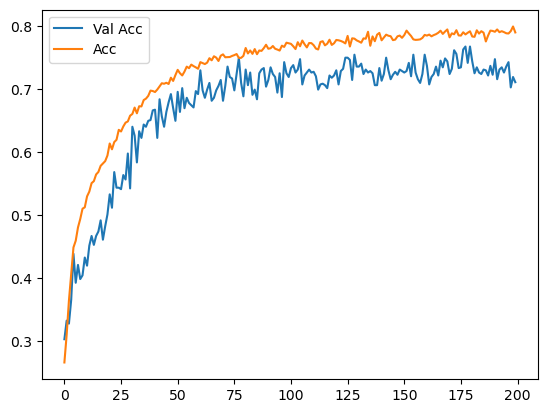

In [ ]:
plt.plot(basic_cnn_model_results.history["val_accuracy"], label="Val Acc")
plt.plot(basic_cnn_model_results.history["accuracy"], label="Acc")
plt.legend()
plt.show()

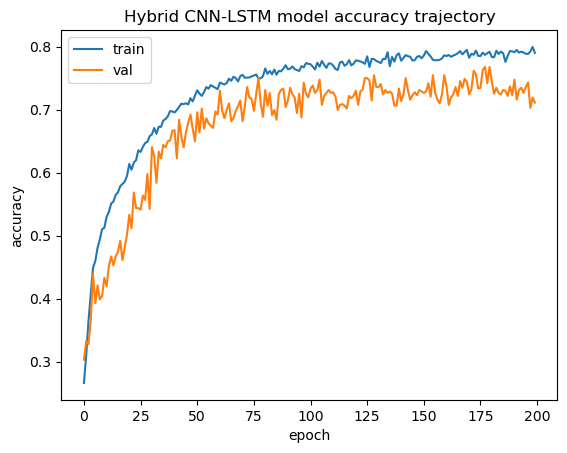

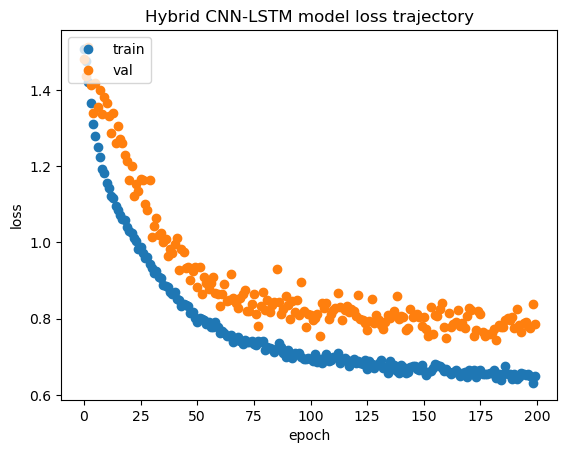

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
best_model = tf.keras.models.load_model("models/best_model.h5")

In [ ]:
## Testing the hybrid CNN-LSTM model
basic_cnn_model_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:', basic_cnn_model_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.7042889595031738


In [ ]:
basic_cnn_score = best_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model that got lowest validation loss:', basic_cnn_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.7200902700424194
